In [2]:
#import tensorflow as tf
import sys
sys.path.append('/nas/longleaf/home/siyangj/NiftyNet/')
#import niftynet as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import os
import re
import sklearn as skl
import pandas as pd

pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 10000

In [3]:
def Dice(pred,true,labels=[0,1,2,3]):
    l = len(labels)
    ret = np.zeros(l)
    for i in range(l):
        lab = labels[i]
        p = pred==lab
        t = true==lab
        ret[i] = 2*np.logical_and(p,t).sum()/(p.sum()+t.sum())
    return ret

In [3]:
def inference_eval(model,inf_dir,data_path,eval_df,test_im,
                   seg_suffix='seg/',skip_if_exist=True):
    inf_re = re.compile(r'inference.*')
    im_re = re.compile(r'.*\.nii\.gz')
    model_path = '/proj/NIRAL/users/siyangj/model_{}/'.format(model)
    
    inf_ims = {f[0]:os.path.join(inf_dir,f) for f in os.listdir(inf_dir) 
            if (os.path.isfile(os.path.join(inf_dir, f)) and im_re.match(f) is not None)}
    l = len(eval_df.index)
    if len(eval_df.loc[eval_df['inf_dir']==inf_dir])>0:
        if skip_if_exist:
            return
        l = np.where(eval_df['inf_dir']==inf_dir)[0][0]
    eval_df.loc[l,'inf_dir']=inf_dir
    eval_df.loc[l,'model']=model
    eval_df.loc[l,'test_im']=test_im
    for im_num,im in inf_ims.items():
        true_im = os.path.join(data_path,seg_suffix,im_num+'.nrrd')
        true_arr = sitk.GetArrayFromImage(sitk.ReadImage(true_im))
        #print(true_arr.shape)
        inf_arr = sitk.GetArrayFromImage(sitk.ReadImage(im))
        #print(inf_arr.shape)
        c_mat = skl.metrics.confusion_matrix(true_arr.flatten(),inf_arr.flatten())
        p_mat = c_mat.T / c_mat.astype(np.float).sum(axis=1)
        eval_df.loc[l,im_num]=[p_mat.T]
        if im_num == test_im:
            eval_df.loc[l,'test_11'] = p_mat[1,1]
            eval_df.loc[l,'test_12'] = p_mat[2,1]
            eval_df.loc[l,'test_21'] = p_mat[1,2]
            eval_df.loc[l,'test_22'] = p_mat[2,2]
            eval_df.loc[l,'test_11+22'] = eval_df.loc[l,'test_11']+eval_df.loc[l,'test_22']
            eval_df.loc[l,'test_12+21'] = eval_df.loc[l,'test_12']+eval_df.loc[l,'test_21']
            Dice0123 = Dice(inf_arr,true_arr)
            eval_df.loc[l,'Dice0'] = Dice0123[0]
            eval_df.loc[l,'Dice1'] = Dice0123[1]
            eval_df.loc[l,'Dice2'] = Dice0123[2]
            eval_df.loc[l,'Dice3'] = Dice0123[3]

In [55]:
seg = sitk.ReadImage('/proj/NIRAL/users/siyangj/myData/min_normal/seg_inf_1/1.nrrd')

In [56]:
inf = sitk.ReadImage('/proj/NIRAL/users/siyangj/NiftyNetModels/model_10112055/inference_21900_normal/1_niftynet_out.nii.gz')

In [57]:
cr_mask = sitk.ReadImage('/proj/NIRAL/users/siyangj/myData/min_normal/CerebellumMask/1.nrrd')

In [66]:
seg_arr = sitk.GetArrayFromImage(seg)
inf_arr = sitk.GetArrayFromImage(inf)
mask_arr = sitk.GetArrayFromImage(cr_mask)

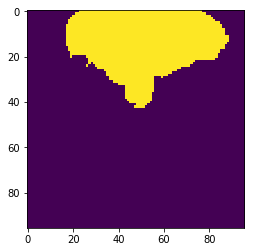

In [67]:
plt.imshow(mask_arr[:,70,:])

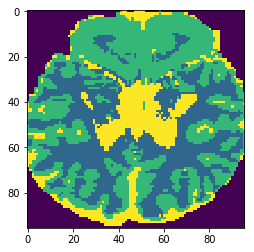

In [68]:
plt.imshow(seg_arr[:,70,:])

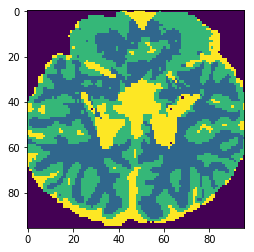

In [69]:
plt.imshow(inf_arr[:,70,:])

In [70]:
cr_part_mask = mask_arr==1
non_cr_mask = mask_arr==0

In [71]:
inf_non_cr = np.copy(inf_arr)
inf_non_cr[cr_part_mask]=0
inf_cr = np.copy(inf_arr)
inf_cr[non_cr_mask]=0
seg_non_cr = np.copy(seg_arr)
seg_non_cr[cr_part_mask]=0
seg_cr = np.copy(seg_arr)
seg_cr[non_cr_mask]=0

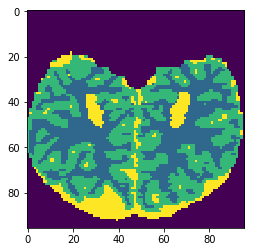

In [81]:
plt.imshow(seg_non_cr[:,80,:])

In [73]:
Dice(inf_non_cr,seg_non_cr)

array([0.99751389, 0.86081243, 0.85482516, 0.86913558])

In [74]:
Dice(inf_cr,seg_cr)

array([0.9992949 , 0.52222164, 0.79935967, 0.75541118])